In [164]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

import statsmodels.api as sm
import pycaret.regression as pycr
import pycaret.utils as pycu
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objs as go
from plotly.subplots import make_subplots


In [165]:
# load final clean dataset
df = pd.read_csv('merged_clean_data.csv')
for_prediction = df.copy()

In [166]:
# convert date/time to date time format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
for_prediction['Date/Time'] = pd.to_datetime(df['Date/Time'])

# filter data to remove the rows that doesn't have productivity values
df = df[df['Date/Time'] <= '2021-12-31']

# set date/time as index
df.set_index('Date/Time', inplace = True)
for_prediction.set_index('Date/Time', inplace = True)


# drop unnecessary columns
sectors_todrop = ['Manufacturing', 'Utilities', 'Educational services', 'Accommodation and food services', 'Other services except public administration',
                  'Public administration', 'Finance and insurance, real estate and rental and leasing', 'Professional scientific and technical services',
                  'Information culture and recreation']

df.drop(columns = sectors_todrop, inplace = True)

# rename columns
df.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)
for_prediction.rename(columns={'Agriculture forestry fishing hunting, Mining quarrying and oil and gas extraction': 'Agriculture'}, inplace=True)


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 85601 entries, 1998-01-01 to 2017-12-01
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   provincename                       85601 non-null  object 
 1   Longitude                          85601 non-null  float64
 2   Latitude                           85601 non-null  float64
 3   Region.Name                        85601 non-null  object 
 4   Construction                       85601 non-null  float64
 5   Transportation and warehousing     85601 non-null  float64
 6   Health care and social assistance  85601 non-null  float64
 7   Agriculture                        85601 non-null  float64
 8   Wholesale trade Retail trade       85601 non-null  float64
 9   Population                         85601 non-null  float64
 10  GeoUID                             85601 non-null  int64  
 11  Station Name                       85

In [168]:
# filter for ontario
df = df[df['provincename'] == 'Quebec']

In [169]:
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = df.select_dtypes(include = ['number'])

# resample numeric data
resampled = num_cols.resample("M").mean()

print(resampled.isnull().sum())

Longitude                            0
Latitude                             0
Construction                         0
Transportation and warehousing       0
Health care and social assistance    0
Agriculture                          0
Wholesale trade Retail trade         0
Population                           0
GeoUID                               0
Mean Max Temp (°C)                   0
Mean Min Temp (°C)                   0
Mean Temp (°C)                       0
Extr Max Temp (°C)                   0
Extr Min Temp (°C)                   0
Total Rain (mm)                      0
Total Snow (cm)                      0
Total Precip (mm)                    0
Snow Grnd Last Day (cm)              0
Dir of Max Gust (10s deg)            0
Spd of Max Gust (km/h)               0
dtype: int64


In [170]:
for_prediction = for_prediction[for_prediction['provincename'] == 'Quebec']
# RESAMPLING THE DATASET TO MONTHLY #

# split data into numeric and string
num_cols = for_prediction.select_dtypes(include = ['number'])

# resample numeric data
resampled_for_prediction = num_cols.resample("M").mean()

print(resampled_for_prediction.isnull().sum())

Longitude                                                     0
Latitude                                                      0
Utilities                                                    25
Construction                                                 25
Manufacturing                                                25
Transportation and warehousing                               25
Educational services                                         25
Health care and social assistance                            25
Accommodation and food services                              25
Other services except public administration                  25
Public administration                                        25
Agriculture                                                  25
Wholesale trade Retail trade                                 25
Finance and insurance, real estate and rental and leasing    25
Professional scientific and technical services               25
Information culture and recreation      

<Axes: >

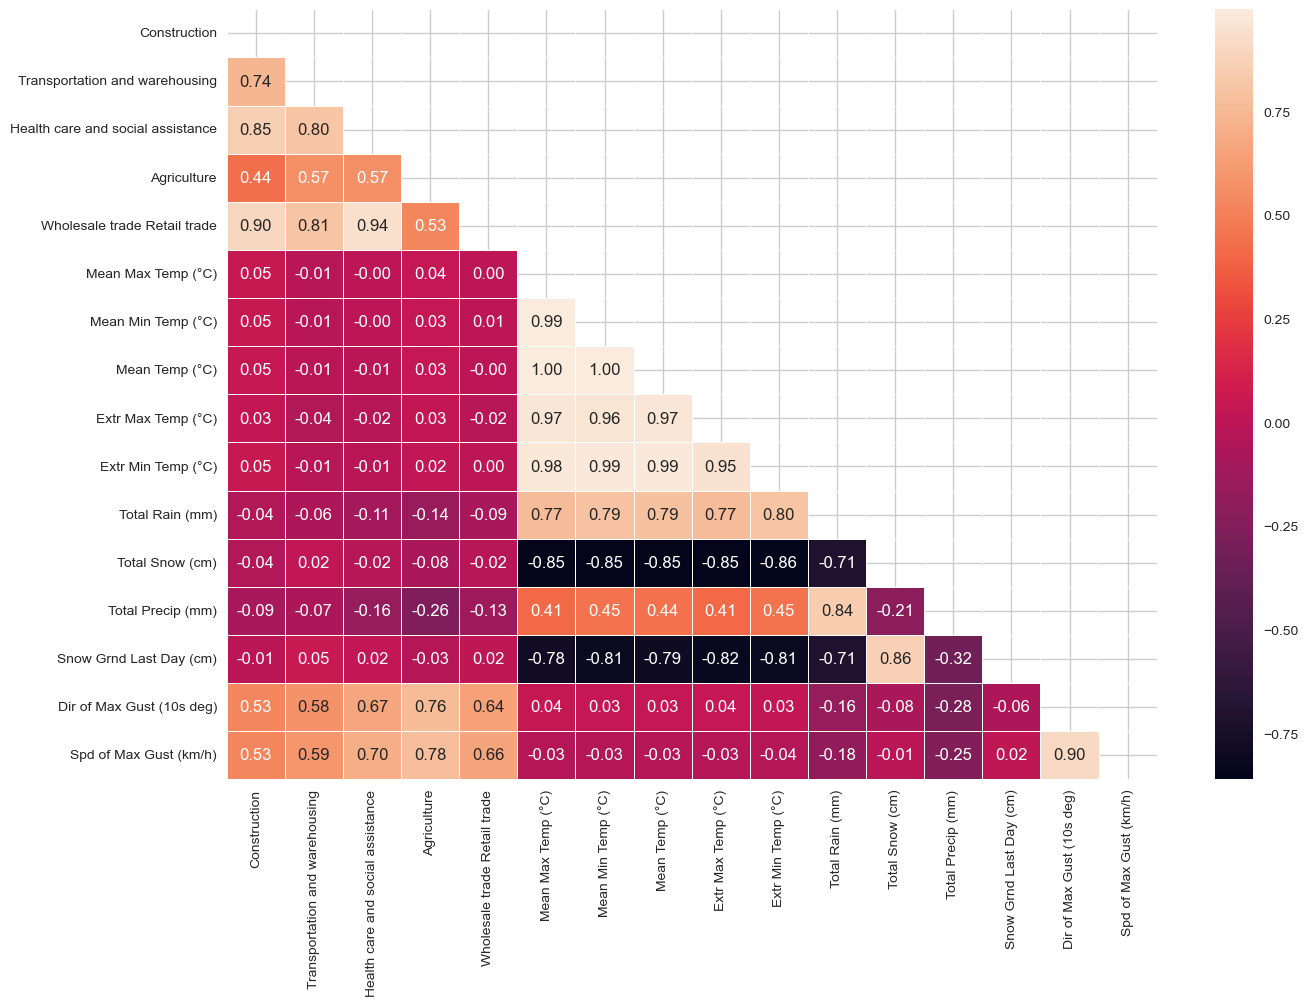

In [171]:
# CORRELATION MATRIX for combination of all 5 provinces #

# numeric columns
num_df = resampled.select_dtypes(include = ['number'])

# columns to exclude
to_drop = ['Longitude', 'Latitude', 'GeoUID', 'Population']

num_df.drop(columns = to_drop, inplace = True)

# correlation matrix
corr_matrix = num_df.corr()

# to remove the upper portion of the matrix; contains the same information
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# correlation matrix heatmap
plt.figure(figsize= (15, 10))
sns.heatmap(corr_matrix, mask = mask, annot = True, fmt = '.2f', linewidths= 0.5)

(1) Target Variable: Construction

In [172]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Transportation and warehousing', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

In [173]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Construction', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Construction
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,9.9632,156.2429,12.2916,-0.0389,0.1855,0.1551,0.0160
omp,Orthogonal Matching Pursuit,10.2473,159.0652,12.4862,-0.0485,0.1887,0.1613,0.0070
dummy,Dummy Regressor,10.3155,158.9815,12.4961,-0.0507,0.1889,0.1623,0.0050
rf,Random Forest Regressor,9.9878,158.4513,12.4412,-0.0554,0.1878,0.1572,0.0280
br,Bayesian Ridge,10.3275,160.3671,12.5457,-0.0584,0.1896,0.1625,0.0060
lr,Linear Regression,10.0879,158.7487,12.5007,-0.0707,0.1884,0.1580,0.6150
xgboost,Extreme Gradient Boosting,10.0138,161.5912,12.5059,-0.0818,0.1896,0.1571,0.0310
llar,Lasso Least Angle Regression,10.4537,165.5807,12.7354,-0.0902,0.1921,0.1644,0.0100
lasso,Lasso Regression,10.4537,165.5821,12.7354,-0.0902,0.1921,0.1644,0.4870
ridge,Ridge Regression,10.4937,163.2687,12.6732,-0.0920,0.1905,0.1643,0.0070


K Neighbors Regressor

In [174]:
# model creation using PyCaret
model = pycr.create_model('knn', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.2242,200.1453,14.1473,-0.2868,0.2233,0.1877
1,11.7902,203.9160,14.2799,-0.4086,0.2123,0.1771
2,11.3802,208.6402,14.4444,-0.2793,0.2222,0.1871
3,10.6675,171.0037,13.0768,-0.0263,0.1929,0.1668
4,11.7237,174.3690,13.2049,-0.1868,0.1836,0.1638
Mean,11.3572,191.6149,13.8307,-0.2376,0.2069,0.1765
Std,0.4039,15.7238,0.5725,0.1270,0.0160,0.0099


{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [175]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbors Regressor: Actual vs Predicted Construction (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,9.9377,156.0088,12.4903,0.0374,0.1887,0.1567


R-squared (R2) Score: 0.037403703353871


In [176]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)


# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbor Regressor: Actual vs Predicted Construction (Test Dataset)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,23.1135,651.1756,25.5181,-2.7659,0.3263,0.2597


R-squared (R2) Score: -2.7658781572940585


In [177]:
# tuning the pycaret model

model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.9433,132.3259,11.5033,-0.0343,0.1834,0.1522
1,11.7492,206.4492,14.3683,-0.1822,0.2284,0.1904
2,10.6277,154.1188,12.4145,-0.0153,0.1797,0.1569
3,10.0361,136.2714,11.6735,-0.0084,0.1803,0.1609
4,12.6500,238.5342,15.4446,-0.0523,0.2389,0.2055
5,7.7936,103.8597,10.1912,-0.2026,0.1587,0.1316
6,7.5977,103.6902,10.1828,-0.0497,0.1587,0.1268
7,11.4542,214.6371,14.6505,0.0834,0.2215,0.1887
8,10.1202,142.9867,11.9577,0.0572,0.1654,0.1424


Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'manhattan', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 48, 'p': 2, 'weights': 'uniform'}


In [178]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbor Regressor: Actual vs Predicted Construction (Training Dataset)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,10.1779,163.0666,12.7698,-0.0061,0.1945,0.1626


R-squared (R2) Score: -0.00614386861761429


In [179]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Construction'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Construction'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='K Neighbors Regressor: Actual vs Predicted Construction (Test Dataset)',
                  title_font_size=15, title_y=0.95, 
                  xaxis_title='Date/Time', yaxis_title='Construction',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,20.8434,537.7412,23.1892,-2.1099,0.2892,0.2332


R-squared (R2) Score: -2.1098648468518992


(2) Target Variable: Transportation and warehousing

In [180]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Health care and social assistance',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
test_data = resampled_con[resampled_con.index > train_end_date]

In [181]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Transportation and warehousing', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Transportation and warehousing
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,2.2824,7.7756,2.7560,-0.0101,0.0807,0.0691,0.0080
gbr,Gradient Boosting Regressor,2.3331,8.2162,2.8261,-0.0625,0.0827,0.0705,0.0210
rf,Random Forest Regressor,2.3580,8.3539,2.8447,-0.0786,0.0833,0.0714,0.0250
ridge,Ridge Regression,2.4022,8.2094,2.8461,-0.0831,0.0833,0.0727,0.0060
lasso,Lasso Regression,2.3877,8.2439,2.8536,-0.0946,0.0837,0.0724,0.0070
llar,Lasso Least Angle Regression,2.3877,8.2438,2.8536,-0.0946,0.0837,0.0724,0.0080
br,Bayesian Ridge,2.3771,8.2686,2.8580,-0.0961,0.0839,0.0722,0.0090
en,Elastic Net,2.4020,8.3122,2.8654,-0.1031,0.0840,0.0728,0.0080
dummy,Dummy Regressor,2.4080,8.3893,2.8789,-0.1044,0.0845,0.0732,0.0050
omp,Orthogonal Matching Pursuit,2.3845,8.3535,2.8708,-0.1075,0.0843,0.0725,0.0060


Linear Regression

In [182]:
# model creation using PyCaret
model = pycr.create_model('lr', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.7541,5.3610,2.3154,0.1868,0.0667,0.0521
1,2.6816,10.9611,3.3108,0.0510,0.0958,0.0803
2,2.4608,8.2344,2.8696,-0.0335,0.0865,0.0775
3,1.8266,5.1728,2.2744,0.2030,0.0687,0.0573
4,2.5917,9.0812,3.0135,-0.2323,0.0860,0.0747
Mean,2.2630,7.7621,2.7567,0.0350,0.0807,0.0684
Std,0.3929,2.2211,0.4033,0.1598,0.0112,0.0114


{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


In [183]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Transportation and warehousing'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Linear Regression: Actual vs Predicted Transportation and warehousing (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

R-squared (R2) Score: 0.1319340822418652


In [184]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Transportation and warehousing'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)


# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Linear Regression: Actual vs Predicted Transportation and warehousing (Test Dataset)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,16.0338,436.3756,20.8896,-12.2448,1.1215,0.3958


R-squared (R2) Score: -12.244764223223735


In [185]:
# tuning the pycaret model

model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:07:21
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.0542,7.0722,2.6594,0.0027,0.0778,0.0632
1,1.5076,3.9238,1.9809,0.1901,0.0559,0.0431
2,2.6064,9.0872,3.0145,0.2575,0.0868,0.0775
3,2.6766,12.1350,3.4835,-0.1342,0.1013,0.0810
4,2.4975,8.1237,2.8502,-0.0019,0.0850,0.0763
5,2.5477,8.9969,2.9995,-0.3445,0.0911,0.0824
6,1.8801,5.0951,2.2572,0.1731,0.0681,0.0585
7,1.9006,5.9904,2.4475,0.1088,0.0736,0.0598
8,2.2689,7.2411,2.6909,-0.2157,0.0762,0.0645


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'positive': False}


In [186]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Transportation and warehousing'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Linear Regression: Actual vs Predicted Transportation and warehousing (Training Dataset)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.1869,7.4635,2.7319,0.1319,0.0798,0.0663


R-squared (R2) Score: 0.1319340822418652


In [187]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Transportation and warehousing'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Transportation and warehousing'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Linear Regression: Actual vs Predicted Transportation and warehousing (Test Dataset)',
                  title_font_size=15, title_y=0.95, 
                  xaxis_title='Date/Time', yaxis_title='Transportation and warehousing',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,16.0338,436.3756,20.8896,-12.2448,1.1215,0.3958


R-squared (R2) Score: -12.244764223223735


(3) Target Variable: Health care and social assistance

In [188]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Agriculture', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [189]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Health care and social assistance', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Health care and social assistance
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,6.5938,64.3729,7.8914,0.0221,0.0856,0.0726,0.0180
lr,Linear Regression,6.7538,65.3168,8.0352,-0.0197,0.0877,0.0749,0.0080
lightgbm,Light Gradient Boosting Machine,6.7765,66.9208,8.0805,-0.0232,0.0878,0.0746,0.0320
rf,Random Forest Regressor,6.9408,68.3503,8.1656,-0.0459,0.0886,0.0764,0.0290
dummy,Dummy Regressor,7.2443,69.1382,8.2769,-0.0588,0.0900,0.0800,0.0060
br,Bayesian Ridge,7.2578,69.5396,8.2977,-0.0639,0.0902,0.0801,0.0060
ada,AdaBoost Regressor,7.0734,69.7755,8.2934,-0.0745,0.0902,0.0782,0.0180
omp,Orthogonal Matching Pursuit,7.3004,70.6507,8.3575,-0.0793,0.0908,0.0806,0.0060
ridge,Ridge Regression,7.2353,70.7284,8.3846,-0.0976,0.0911,0.0800,0.0080
llar,Lasso Least Angle Regression,7.4066,72.0707,8.4512,-0.1059,0.0918,0.0817,0.0090


Gradient Boosting Regressor

In [190]:
# model creation using PyCaret
model = pycr.create_model('gbr', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.2412,77.1581,8.7840,-0.0150,0.0943,0.0787
1,7.2025,80.9599,8.9978,-0.0332,0.0967,0.0777
2,6.1811,67.5174,8.2169,-0.0688,0.0913,0.0711
3,5.6129,48.2300,6.9448,0.1598,0.0760,0.0635
4,6.2570,54.5946,7.3888,0.0652,0.0797,0.0676
Mean,6.4990,65.6920,8.0664,0.0216,0.0876,0.0717
Std,0.6310,12.6173,0.7902,0.0819,0.0082,0.0058


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1234, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [191]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Health care and social assistance'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Health care and social assistance (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,3.0043,17.3266,4.1625,0.7494,0.0449,0.0329


R-squared (R2) Score: 0.7493519741292475


In [192]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Health care and social assistance'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)


# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Health care and social assistance (Test Dataset)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

R-squared (R2) Score: -1.4562464820013998


In [193]:
# tuning the pycaret model

model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:08:43
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0113,62.9590,7.9347,0.0054,0.0863,0.0776
1,8.7690,96.0728,9.8017,-0.1656,0.1028,0.0915
2,7.9714,79.1104,8.8944,-0.0755,0.0937,0.0842
3,7.9440,79.8728,8.9372,0.0067,0.0979,0.0886
4,5.5327,53.0727,7.2851,-0.0032,0.0804,0.0619
5,7.6267,80.5324,8.9740,-0.1983,0.1006,0.0893
6,6.4201,58.8663,7.6724,-0.1022,0.0855,0.0738
7,6.7527,60.8602,7.8013,-0.0036,0.0856,0.0756
8,6.7518,53.2768,7.2991,0.0036,0.0787,0.0738


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1234, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [194]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Health care and social assistance'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Health care and social assistance (Training Dataset)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

R-squared (R2) Score: 0.7493519741292475


In [195]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Health care and social assistance'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Health care and social assistance'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Health care and social assistance (Test Dataset)',
                  title_font_size=15, title_y=0.95, 
                  xaxis_title='Date/Time', yaxis_title='Health care and social assistance',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,21.4567,529.3585,23.0078,-1.4562,0.2204,0.1892


R-squared (R2) Score: -1.4562464820013998


(4) Target Variable: Agriculture

In [196]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Wholesale trade Retail trade']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [197]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Agriculture', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Agriculture
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dummy,Dummy Regressor,2.6431,10.2280,3.1936,-0.0962,0.1156,0.1002,0.0090
llar,Lasso Least Angle Regression,2.6922,10.3466,3.2088,-0.1065,0.1160,0.1018,0.0090
lasso,Lasso Regression,2.6922,10.3466,3.2088,-0.1065,0.1160,0.1018,0.0070
en,Elastic Net,2.6975,10.4181,3.2191,-0.1143,0.1163,0.1019,0.0070
br,Bayesian Ridge,2.7002,10.4970,3.2362,-0.1268,0.1171,0.1023,0.0080
omp,Orthogonal Matching Pursuit,2.7605,10.8555,3.2893,-0.1642,0.1189,0.1044,0.0080
ridge,Ridge Regression,2.7704,11.2809,3.3450,-0.2033,0.1208,0.1046,0.0100
lr,Linear Regression,2.7674,11.3146,3.3466,-0.2051,0.1209,0.1044,0.0070
rf,Random Forest Regressor,2.7404,11.2327,3.3427,-0.2238,0.1208,0.1036,0.0310
ada,AdaBoost Regressor,2.7699,11.6065,3.4016,-0.2598,0.1231,0.1050,0.0160


Lasso Least Angle Regression

In [198]:
# model creation using PyCaret
model = pycr.create_model('llar', fold = 5)

params = model.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.6068,9.7707,3.1258,-0.0061,0.1165,0.1009
1,2.6683,11.5328,3.3960,-0.1150,0.1146,0.0921
2,2.5650,9.3284,3.0542,-0.1902,0.1150,0.1039
3,2.6913,9.7633,3.1246,-0.0364,0.1138,0.1029
4,2.7954,10.6784,3.2678,0.0274,0.1168,0.1036
Mean,2.6654,10.2147,3.1937,-0.0641,0.1153,0.1007
Std,0.0789,0.7923,0.1227,0.0787,0.0011,0.0044


{'alpha': 1.0, 'copy_X': True, 'eps': 2.220446049250313e-16, 'fit_intercept': True, 'fit_path': True, 'jitter': None, 'max_iter': 500, 'positive': False, 'precompute': 'auto', 'random_state': 1234, 'verbose': False}


In [199]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

R-squared (R2) Score: 0.022100077021424913


In [200]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture (Training data)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [201]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.3137,118.9110,10.9046,-8.1427,0.3196,0.2663


R-squared (R2) Score: -8.142678151837485


In [202]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Agriculture'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture (Test data)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [203]:
model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.7020,9.9432,3.1533,0.0094,0.1183,0.1070
1,2.7674,11.3463,3.3684,-0.3179,0.1243,0.1045
2,2.5862,12.4380,3.5268,-0.2640,0.1170,0.0864
3,2.7624,10.3786,3.2216,0.0208,0.1113,0.0992
4,2.2539,7.0810,2.6610,-0.0776,0.1003,0.0918
5,2.7650,10.8432,3.2929,-0.2244,0.1240,0.1111
6,2.6947,9.6013,3.0986,-0.0500,0.1085,0.0968
7,2.7505,10.5741,3.2518,-0.2255,0.1222,0.1115
8,2.9038,12.3846,3.5192,-0.1246,0.1209,0.1039


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'alpha': 1.0, 'copy_X': True, 'eps': 2.220446049250313e-16, 'fit_intercept': True, 'fit_path': True, 'jitter': None, 'max_iter': 500, 'positive': False, 'precompute': 'auto', 'random_state': 1234, 'verbose': False}


In [204]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture (Training Dataset)',
                  title_font_size=15, title_y=.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,2.6133,10.1839,3.1912,0.0221,0.1132,0.0971


R-squared (R2) Score: 0.022100077021424913


In [205]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Agriculture'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)


# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True)

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Agriculture'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Lasso Least Angle Regression: Actual vs Predicted Agriculture (Test Dataset)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Agriculture',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Least Angle Regression,10.3137,118.9110,10.9046,-8.1427,0.3196,0.2663


R-squared (R2) Score: -8.142678151837485


(5) Target Variable: Wholesale trade Retail trade

In [206]:
# drop columns
ignore_features = ['Longitude', 'Latitude', 'Population', 'GeoUID', 
                   'Construction', 'Transportation and warehousing',
                   'Health care and social assistance', 'Agriculture']
resampled_con = resampled.drop(columns = ignore_features)
# resampled['Year'] = resampled.index.year

# Filter the data based on the date range
train_end_date = '2016-12-31'

# Filter the data based on the date range
train_data = resampled_con[resampled_con.index <= train_end_date]
# train_data = train_data[['Mean Max Temp (°C)', 'Construction']]
test_data = resampled_con[resampled_con.index > train_end_date]
# test_data = train_data[['Mean Max Temp (°C)', 'Construction']]


In [207]:
# set up the pycaret
pycaret_experiment = pycr.setup(data=train_data, target='Wholesale trade Retail trade', session_id=1234,
                                preprocess = False)
# to check which model is the best to predict the target variable
best = pycr.compare_models(sort='R2')                    

,Description,Value
0,Session id,1234
1,Target,Wholesale trade Retail trade
2,Target type,Regression
3,Original data shape,"(228, 12)"
4,Transformed data shape,"(228, 12)"
5,Transformed train set shape,"(159, 12)"
6,Transformed test set shape,"(69, 12)"
7,Numeric features,11


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,12.2281,224.3827,14.6882,0.0515,0.1432,0.1210,0.0190
lr,Linear Regression,12.9950,233.1173,15.1811,0.0101,0.1476,0.1289,0.0080
rf,Random Forest Regressor,12.6893,238.0938,15.2390,-0.0068,0.1481,0.1259,0.0310
lightgbm,Light Gradient Boosting Machine,12.9269,243.1583,15.3733,-0.0210,0.1497,0.1283,0.0370
ridge,Ridge Regression,13.6339,245.5457,15.6404,-0.0488,0.1517,0.1350,0.0070
dummy,Dummy Regressor,13.5272,247.4070,15.6874,-0.0491,0.1528,0.1347,0.0060
br,Bayesian Ridge,13.5467,248.0618,15.7078,-0.0520,0.1529,0.1349,0.0080
xgboost,Extreme Gradient Boosting,12.9653,247.8753,15.6263,-0.0546,0.1516,0.1278,0.0240
ada,AdaBoost Regressor,13.3001,249.6180,15.7048,-0.0561,0.1525,0.1309,0.0160
omp,Orthogonal Matching Pursuit,13.6174,249.4086,15.7470,-0.0575,0.1532,0.1354,0.0070


Gradient Boosting Regressor

In [208]:
# model creation using PyCaret
model = pycr.create_model('gbr', fold = 5)

params = model.get_params()
print(params)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:10:13
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.2128,240.8936,15.5207,-0.0006,0.1491,0.1291
1,16.2447,391.8847,19.7961,-0.3967,0.1881,0.1595
2,12.1656,264.2673,16.2563,-0.1138,0.1616,0.1246
3,9.2134,141.4743,11.8943,0.3784,0.1244,0.1002
4,13.0118,239.8894,15.4884,-0.1019,0.1450,0.1198
Mean,12.7696,255.6819,15.7912,-0.0469,0.1537,0.1266
Std,2.2514,80.1703,2.5142,0.2502,0.0210,0.0192


{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1234, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [209]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = train_data)

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.5670,58.9191,7.6759,0.7585,0.0751,0.0549


R-squared (R2) Score: 0.7585417621359622


In [210]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Wholesale trade Retail trade (Training data)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [211]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model, data = test_data)
r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

R-squared (R2) Score: -3.6949126950536826


In [212]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Wholesale trade Retail trade (Test data)',
                  title_font_size=15, title_y=0.95,
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [213]:
model_tuned = pycr.tune_model(model)
params = model_tuned.get_params()
print(params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.4496,232.0928,15.2346,0.0143,0.1526,0.1299
1,14.6499,252.7741,15.8989,-0.1365,0.1461,0.1338
2,15.8176,289.6763,17.0199,-0.0463,0.1597,0.1508
3,14.6794,279.1635,16.7082,0.0129,0.1631,0.1464
4,11.0433,205.9281,14.3502,-0.0073,0.1463,0.1144
5,13.2154,269.8852,16.4282,-0.0174,0.1636,0.1378
6,9.8227,180.5941,13.4385,-0.1447,0.1376,0.1069
7,14.9326,289.1264,17.0037,0.0174,0.1720,0.1576
8,13.9076,232.4010,15.2447,-0.0112,0.1411,0.1300


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 1234, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


In [214]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = train_data)
predictions.head()

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,5.5670,58.9191,7.6759,0.7585,0.0751,0.0549


R-squared (R2) Score: 0.7585417621359622


In [215]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Wholesale trade Retail trade (Training data)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()

In [216]:
# Make predictions on the test dataset
predictions = pycr.predict_model(model_tuned, data = test_data)

r2 = r2_score(predictions['Wholesale trade Retail trade'], predictions['prediction_label'])
print('R-squared (R2) Score:', r2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,37.4455,1738.6272,41.6968,-3.6949,0.3394,0.2580


R-squared (R2) Score: -3.6949126950536826


In [217]:
# Sort predictions DataFrame by index
predictions.sort_index(inplace=True)

# Create Plotly figure
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, shared_yaxes=True, 
                    subplot_titles=('Extra Trees Regressor: Actual vs Predicted Wholesale trade Retail trade'))

# Add scatter plot for actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'],
                         mode='markers', marker=dict(color='blue', opacity=0.5),
                         name='Actual'), row=1, col=1)

# Add scatter plot for predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'],
                         mode='markers', marker=dict(color='red'),
                         name='Predicted'), row=1, col=1)

# Add lines for sorted actual values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['Wholesale trade Retail trade'].sort_index(),
                         mode='lines', line=dict(color='blue', dash='dash'),
                         showlegend=False), row=1, col=1)

# Add lines for sorted predicted values
fig.add_trace(go.Scatter(x=predictions.index, y=predictions['prediction_label'].sort_index(),
                         mode='lines', line=dict(color='red', dash='dash'),
                         showlegend=False), row=1, col=1)

fig.update_layout(title_text='Gradient Boosting Regressor: Actual vs Predicted Wholesale trade Retail trade (Test data)',
                  title_font_size=15, title_y=0.95,  # Adjusted title_y value
                  xaxis_title='Date/Time', yaxis_title='Wholesale trade Retail trade',
                  legend=dict(x=0.02, y=0.98),
                  grid=dict(rows=1, columns=1, ygap=0.2))

# Show interactive plot
fig.show()